In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pickle
from scipy.stats import beta, sem
from pybad.bad.sbinom import *
from pybad.tasks.memory_retention import pow_f, exp_f
from pybad.models import *

In [2]:
powm_low = BinaryClassModel(f=pow_f, prior=beta(a=[1.,1.], b=[1.,2.]))
powm_unif_par = BinaryClassModel(f=pow_f, prior=beta(a=[1.,1.], b=[1.,1.]))
powm_high = BinaryClassModel(f=pow_f, prior=beta(a=[1.,2.], b=[1.,1.]))
powm_unif_data = BinaryClassModel(f=pow_f, prior=beta(a=[2.,1.], b=[1.,4.]))

In [3]:
colors = [
    [27,158,119],[217,95,2],[117,112,179],[231,41,138],[102,166,30],[230,171,2]
]
linecolors = np.array([
    f"rgba({','.join(map(str,color))},1)" for color in colors
])
fillcolors = np.array([
    f"rgba({','.join(map(str,color))},.2)" for color in colors
])

In [4]:
xx = np.arange(101)[:,None]

In [5]:
def lines_plus_shading(x, mn, sd, line_kwds, trace_kwds):
    up = go.Scatter(
        x=x, y=mn+sd, mode="lines", line=dict(width=0., **line_kwds), 
        showlegend=False, **trace_kwds
    )
    mid = go.Scatter(
        x=x, y=mn, fill="tonexty", mode="lines", line=dict(**line_kwds), 
        **trace_kwds
    )
    low = go.Scatter(
        x=x, y=mn-sd, mode="lines", fill="tonexty", 
        line=dict(width=0., **line_kwds), showlegend=False, **trace_kwds
    )
    return up, mid, low

# Figure 5a

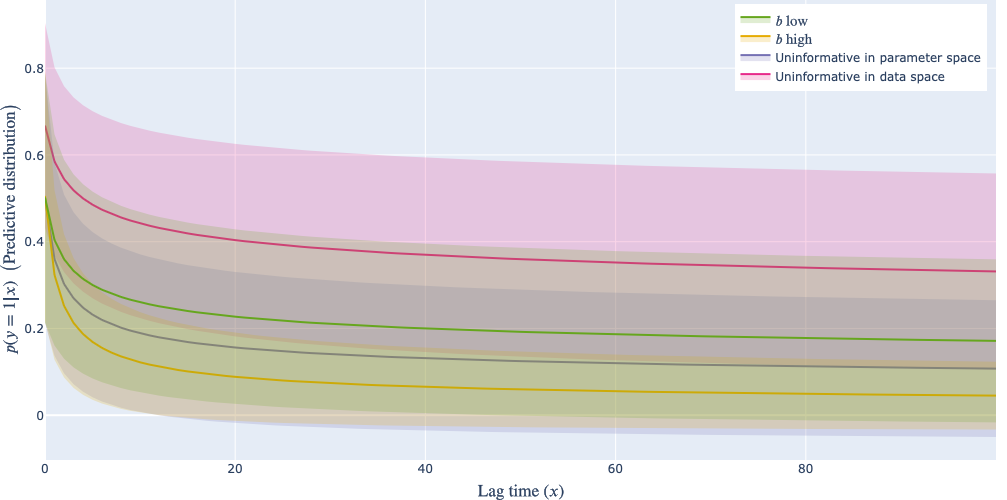

In [6]:
fig = make_subplots(rows=1, cols=1)
for i,m in list(enumerate([powm_low,powm_high,powm_unif_par,powm_unif_data]))[::-1]:
    m.predict(xx, 1)
    traces = lines_plus_shading(
        x=xx.ravel(), mn=m.pred.mean(axis=(0,2)), sd=m.pred.std(axis=(0,2)), 
        line_kwds=dict(color=linecolors[[4,5,2,3]][i]), trace_kwds=dict(
            fillcolor=fillcolors[[4,5,2,3]][i], name=[
                r"$b \text{ low}$",r"$b \text{ high}$",
                "Uninformative in parameter space",
                "Uninformative in data space"
            ][i]))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
size = 500.
fig.update_layout(
    height=size, width=size, legend=dict(
        yanchor="top", y=.99, xanchor="right", x=.99
    ), margin=dict(l=0., r=0., t=0., b=0.))
fig.update_xaxes(title=r"$\text{Lag time (}x\text{)}$")
fig.update_yaxes(title=r"$p(y = 1 \vert x) ~~ \big(\text{Predictive distribution}\big)$")
fig.show()

In [7]:
dat = pickle.load(open("dat_memreten", "rb"))
datInf = dat[:,:,:,:,[0,1],[0,1],:,:]
datMisinf = dat[:,:,:,:,[0,1],[1,0],:,:]
datUninfTheta = dat[:,:,:,:,[0,1],3,:,:]
datUninfY = dat[:,:,:,:,[0,1],2,:,:]

In [8]:
prior_labs = [
    r"$\LARGE{\text{Informative}}$",r"$\LARGE{\text{Misinformative}}$",
    r"$\LARGE{\text{Uninformative in } \theta}$",
    r"$\LARGE{\text{Uninformative in } y}$"
]

# Figure 5b

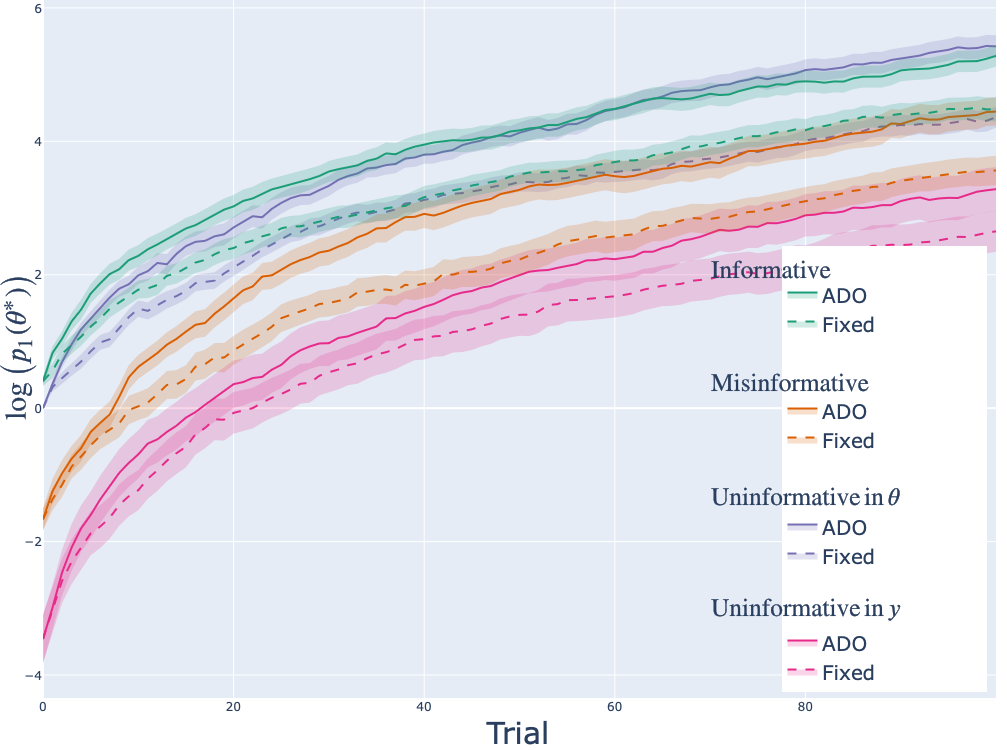

In [9]:
fig = make_subplots(rows=1, cols=1)
for i, thisdat in list(enumerate((
    datInf,datMisinf,datUninfTheta,datUninfY
)))[::-1]:
    for j in range(2)[::-1]:
        yy = thisdat[1,0,0,j,...]
        yy = yy.prod(axis=0)
        yy = yy.reshape((np.prod(yy.shape) // 101,101))
        yy = np.log(yy)
        traces = lines_plus_shading(
            x=np.arange(101), mn=yy.mean(axis=0), sd=sem(yy, axis=0), 
            line_kwds=dict(color=linecolors[i], dash=[None,"dash"][j]), 
            trace_kwds=dict(
                fillcolor=fillcolors[i], name=["ADO","Fixed               "][j]
            ))
        for trace in traces:
            fig.append_trace(trace, row=1, col=1)
        
        if j == 0:
            if i > 0:
                fig.add_trace(go.Scatter(
                    x=[-1.,-1.], y=[1.,1.], mode="markers", 
                    marker=dict(size=0.), line=dict(color="white"), name=""
                ))
            fig.add_trace(go.Scatter(
                x=[-1.,-1.], y=[1.,1.], line=dict(color="white"), name=""
            ))
            fig.add_annotation(
                x=70., y=2.1-1.7*i, xanchor="left", text=prior_labs[i],
                font=dict(size=12.), showarrow=False
            )
            
size = 750.
fig.update_layout(height=size, width=size, legend=dict(
    yanchor="bottom", y=.01, xanchor="right", x=.99, font=dict(size=20.)
), margin=dict(l=0., r=0., t=0., b=0.))
fig.update_xaxes(range=(0.,100.), title="Trial", title_font_size=30.)
fig.update_yaxes(title=r"$\LARGE{\log{\left(p_1(\theta^*)\right)}}$", row=1, col=1)
fig.show()

In [10]:
expm_unif_par = BinaryClassModel(f=exp_f, prior=beta(a=[1.,1.], b=[1.,1.]))
expm_unif_data = BinaryClassModel(f=exp_f, prior=beta(a=[2.,1.], b=[1.,80.]))

# Figure 7a

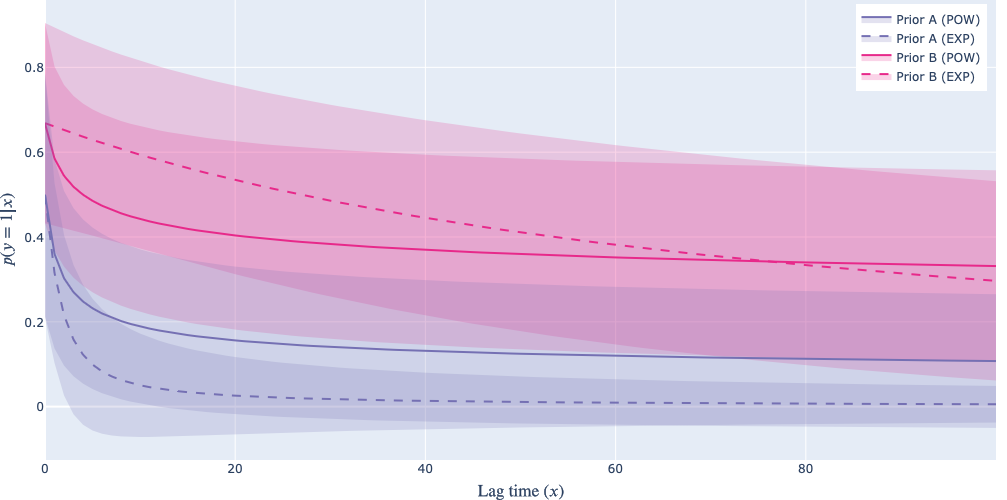

In [11]:
fig = make_subplots(rows=1, cols=1)
for i,m in list(enumerate([
    powm_unif_par,expm_unif_par,powm_unif_data,expm_unif_data
]))[::-1]:
    m.predict(xx, 1)
    traces = lines_plus_shading(
        x=xx.ravel(), mn=m.pred.mean(axis=(0,2)), sd=m.pred.std(axis=(0,2)), 
        line_kwds=dict(
            color=linecolors[[2,3]][i // 2], dash=[None,"dash"][i % 2]
        ), trace_kwds=dict(fillcolor=fillcolors[[2,3]][i // 2], name=[
            "Prior A (POW)",
            "Prior A (EXP)",
            "Prior B (POW)",
            "Prior B (EXP)"
        ][i]))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
fig.update_layout(
    height=500., width=500., legend=dict(
        yanchor="top", y=.99, xanchor="right", x=.99
    ), margin=dict(l=0., r=0., t=0., b=0.))
fig.update_xaxes(title=r"$\text{Lag time (}x\text{)}$")
fig.update_yaxes(title=r"$p(y = 1 \vert x)$")
fig.show()

# Figure 7b

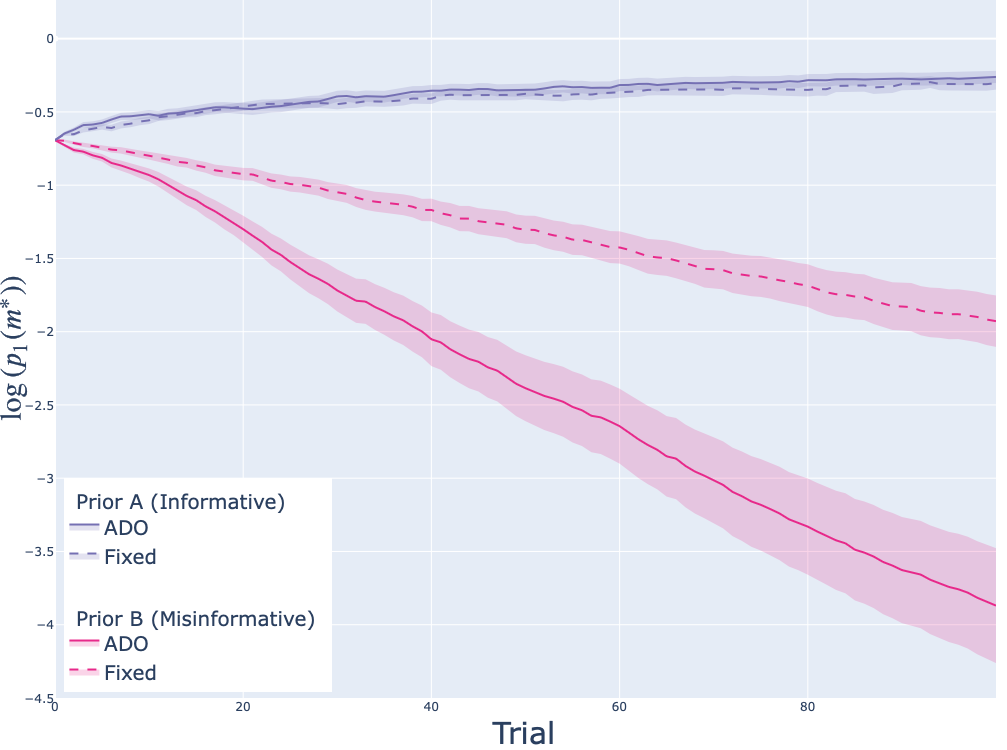

In [12]:
fig = make_subplots(rows=1, cols=1)
for i in range(2)[::-1]:
    yy = dat[0,1,:,i,3,2,...]
    yy = yy.reshape((np.prod(yy.shape) // 101,101))
    yy = np.log(yy)
    traces = lines_plus_shading(
        x=np.arange(101), mn=yy.mean(axis=0), sd=sem(yy, axis=0), 
        line_kwds=dict(color=linecolors[3], dash=[None,"dash"][i]), 
        trace_kwds=dict(
            fillcolor=fillcolors[3], name=["ADO","Fixed                  "][i]
        ))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
fig.add_annotation(
    x=2., y=-3.15, xanchor="left",
    text="Prior A (Informative)",
    font=dict(size=20.), showarrow=False
)
fig.add_trace(go.Scatter(
    x=[0.,0.], y=[0.,0.], line=dict(color="white"), name=""
))
fig.add_trace(go.Scatter(
    x=[0.,0.], y=[0.,0.], line=dict(color="white"), name=""
))
for i in range(2)[::-1]:
    yy = dat[0,1,:,i,3,3,...]
    yy = yy.reshape((np.prod(yy.shape) // 101,101))
    yy = np.log(yy)
    traces = lines_plus_shading(
        x=np.arange(101), mn=yy.mean(axis=0), sd=sem(yy, axis=0), 
        line_kwds=dict(color=linecolors[2], dash=[None,"dash"][i]), 
        trace_kwds=dict(
            fillcolor=fillcolors[2], 
            name=["ADO","Fixed                        "][i]
        ))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
fig.add_annotation(
    x=2., y=-3.95, xanchor="left",
    text="Prior B (Misinformative)", 
    font=dict(size=20.), showarrow=False
)
fig.add_trace(go.Scatter(
    x=[0.,0.], y=[0.,0.], line=dict(color="white"), name=""
))
        
fig.update_layout(height=size, width=size, legend=dict(
    font=dict(size=20.), yanchor="bottom", y=0.01, xanchor="left", x=0.01
), margin=dict(l=0., r=0., t=0., b=0.))
fig.update_xaxes(range=(0.,100.), title="Trial", title_font_size=30.)
fig.update_yaxes(title=r"$\LARGE{\log{\left(p_1(m^*)\right)}}$", row=1, col=1)

# Figure 7c

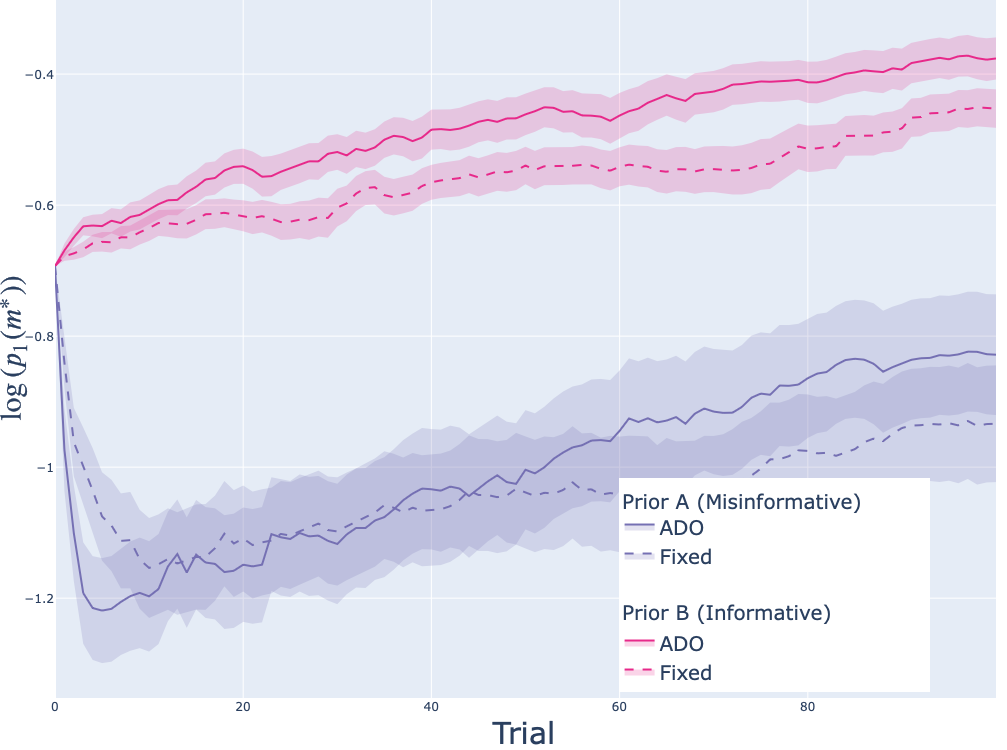

In [13]:
fig = make_subplots(rows=1, cols=1)
for i in range(2)[::-1]:
    yy = dat[0,1,:,i,2,2,...]
    yy = yy.reshape((np.prod(yy.shape) // 101,101))
    yy = np.log(yy)
    traces = lines_plus_shading(
        x=np.arange(101), mn=yy.mean(axis=0), sd=sem(yy, axis=0), 
        line_kwds=dict(color=linecolors[3], dash=[None,"dash"][i]), 
        trace_kwds=dict(
            fillcolor=fillcolors[3], 
            name=["ADO","Fixed                              "][i]
        ))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
fig.add_annotation(
    x=60., y=-1.05, xanchor="left",
    text="Prior A (Misinformative)",
    font=dict(size=20.), showarrow=False
)
fig.add_trace(go.Scatter(
    x=[-1.,-1.], y=[-1.,-1.], line=dict(color="white"), name=""
))
fig.add_trace(go.Scatter(
    x=[-1.,-1.], y=[-1.,-1.], line=dict(color="white"), name=""
))
for i in range(2)[::-1]:
    yy = dat[0,1,:,i,2,3,...]
    yy = yy.reshape((np.prod(yy.shape) // 101,101))
    yy = np.log(yy)
    traces = lines_plus_shading(
        x=np.arange(101), mn=yy.mean(axis=0), sd=sem(yy, axis=0), 
        line_kwds=dict(color=linecolors[2], dash=[None,"dash"][i]), 
        trace_kwds=dict(
            fillcolor=fillcolors[2], 
            name=["ADO","Fixed                              "][i]
        ))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
fig.add_annotation(
    x=60., y=-1.22, xanchor="left",
    text="Prior B (Informative)", 
    font=dict(size=20.), showarrow=False
)
fig.add_trace(go.Scatter(
    x=[-1.,-1.], y=[-1.,-1.], line=dict(color="white"), name=""
))
        
fig.update_layout(height=size, width=size, legend=dict(
    font=dict(size=20.), yanchor="bottom", y=0.01, xanchor="left", x=.60
), margin=dict(l=0., r=0., t=0., b=0.))
fig.update_xaxes(range=(0.,100.), title="Trial", title_font_size=30.)
fig.update_yaxes(title=r"$\LARGE{\log{\left(p_1(m^*)\right)}}$", row=1, col=1)

# Figure 11a

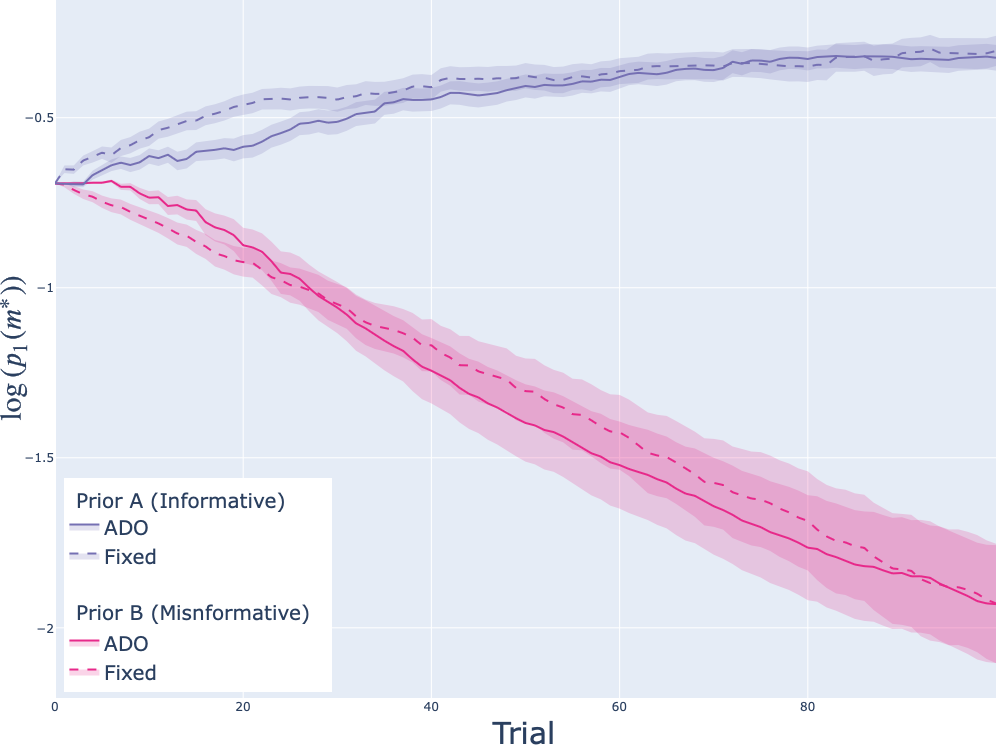

In [14]:
fig = make_subplots(rows=1, cols=1)
for i in range(2)[::-1]:
    yy = dat[0,1,:,[2,1][i],3,2,...]
    yy = yy.reshape((np.prod(yy.shape) // 101,101))
    yy = np.log(yy)
    traces = lines_plus_shading(
        x=np.arange(101), mn=yy.mean(axis=0), sd=sem(yy, axis=0), 
        line_kwds=dict(color=linecolors[3], dash=[None,"dash"][i]), 
        trace_kwds=dict(
            fillcolor=fillcolors[3], name=["ADO","Fixed                  "][i]
        ))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
fig.add_annotation(
    x=2., y=-1.62, xanchor="left",
    text="Prior A (Informative)",
    font=dict(size=20.), showarrow=False
)
fig.add_trace(go.Scatter(
    x=[-1.,-1.], y=[-.5,-.5], line=dict(color="white"), name=""
))
fig.add_trace(go.Scatter(
    x=[-1.,-1.], y=[-.5,-.5], line=dict(color="white"), name=""
))
for i in range(2)[::-1]:
    yy = dat[0,1,:,[2,1][i],3,3,...]
    yy = yy.reshape((np.prod(yy.shape) // 101,101))
    yy = np.log(yy)
    traces = lines_plus_shading(
        x=np.arange(101), mn=yy.mean(axis=0), sd=sem(yy, axis=0), 
        line_kwds=dict(color=linecolors[2], dash=[None,"dash"][i]), 
        trace_kwds=dict(
            fillcolor=fillcolors[2], 
            name=["ADO","Fixed                        "][i]
        ))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
fig.add_annotation(
    x=2., y=-1.95, xanchor="left",
    text="Prior B (Misnformative)",
    font=dict(size=20.), showarrow=False
)
fig.add_trace(go.Scatter(
    x=[-1.,-1.], y=[-.5,-.5], line=dict(color="white"), name=""
))
        
fig.update_layout(height=size, width=size, legend=dict(
    font=dict(size=20.), yanchor="bottom", y=0.01, xanchor="left", x=0.01
), margin=dict(l=0., r=0., t=0., b=0.))
fig.update_xaxes(range=(0.,100.), title="Trial", title_font_size=30.)
fig.update_yaxes(title=r"$\LARGE{\log{\left(p_1(m^*)\right)}}$", row=1, col=1)

# Figure 11b

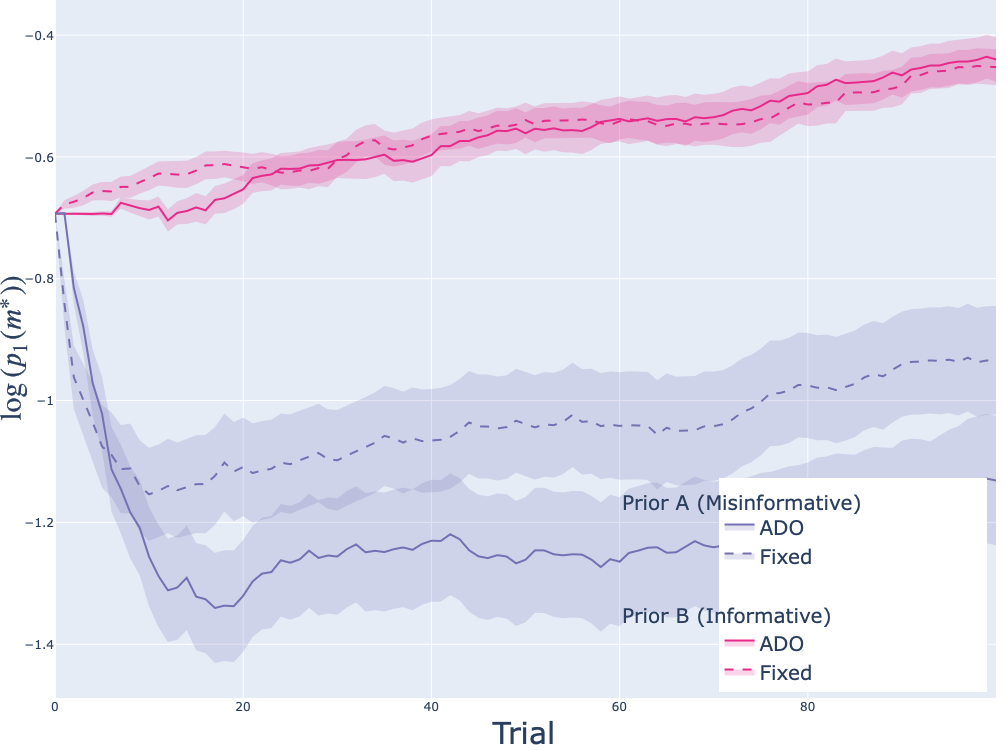

In [15]:
fig = make_subplots(rows=1, cols=1)
for i in range(2)[::-1]:
    yy = dat[0,1,:,[2,1][i],2,2,...]
    yy = yy.reshape((np.prod(yy.shape) // 101,101))
    yy = np.log(yy)
    traces = lines_plus_shading(
        x=np.arange(101), mn=yy.mean(axis=0), sd=sem(yy, axis=0), 
        line_kwds=dict(color=linecolors[3], dash=[None,"dash"][i]), 
        trace_kwds=dict(
            fillcolor=fillcolors[3], name=["ADO","Fixed                  "][i]
        ))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
fig.add_annotation(
    x=60., y=-1.165, xanchor="left",
    text="Prior A (Misinformative)",
    font=dict(size=20.), showarrow=False
)
fig.add_trace(go.Scatter(
    x=[-1.,-1.], y=[-.5,-.5], line=dict(color="white"), name=""
))
fig.add_trace(go.Scatter(
    x=[-1.,-1.], y=[-.5,-.5], line=dict(color="white"), name=""
))
for i in range(2)[::-1]:
    yy = dat[0,1,:,[2,1][i],2,3,...]
    yy = yy.reshape((np.prod(yy.shape) // 101,101))
    yy = np.log(yy)
    traces = lines_plus_shading(
        x=np.arange(101), mn=yy.mean(axis=0), sd=sem(yy, axis=0), 
        line_kwds=dict(color=linecolors[2], dash=[None,"dash"][i]), 
        trace_kwds=dict(
            fillcolor=fillcolors[2], 
            name=["ADO","Fixed                        "][i]
        ))
    for trace in traces:
        fig.append_trace(trace, row=1, col=1)
fig.add_annotation(
    x=60., y=-1.35, xanchor="left",
    text="Prior B (Informative)", 
    font=dict(size=20.), showarrow=False
)
fig.add_trace(go.Scatter(
    x=[-1.,-1.], y=[-.5,-.5], line=dict(color="white"), name=""
))
        
fig.update_layout(height=size, width=size, legend=dict(
    font=dict(size=20.), yanchor="bottom", y=.01, xanchor="right", x=0.99
), margin=dict(l=0., r=0., t=0., b=0.))
fig.update_xaxes(range=(0.,100.), title="Trial", title_font_size=30.)
fig.update_yaxes(title=r"$\LARGE{\log{\left(p_1(m^*)\right)}}$", row=1, col=1)